# Content-Based Filtering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

movies = pd.read_csv('./data/movies_small.csv', sep=';')
movies_big = pd.read_csv('./data/movies.csv', sep=',')
len(movies), len(movies_big)

(6, 4803)

In [2]:
movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,190000000,"[{""id"": 28, ""name"": ""Action""}]",http://www.furious7.com/,168259,"[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",en,Furious 7,Deckard Shaw seeks revenge against Dominic Tor...,102.322217,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}, {""iso_...",2015-04-01,1506249360,137,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Vengeance Hits Home,Furious 7,7.3,4176
1,200000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://www.disney.go.com/cars/,49013,"[{""id"": 830, ""name"": ""car race""}, {""id"": 9663,...",en,Cars 2,Star race car Lightning McQueen and his pal Ma...,49.986590,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2011-06-11,559852396,106,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Ka-ciao!,Cars 2,5.8,2033
2,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,118340,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,773328629,121,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,All heroes start somewhere.,Guardians of the Galaxy,7.9,9742
3,145000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.kungfupanda.com/,140300,"[{""id"": 478, ""name"": ""china""}, {""id"": 779, ""na...",en,Kung Fu Panda 3,"Continuing his ""legendary adventures of awesom...",56.747978,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""CN"", ""name"": ""China""}, {""iso_...",2016-01-23,521170825,95,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Grab destiny by the rice dumplings.,Kung Fu Panda 3,6.7,1603
4,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
5,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [3]:
# دمج الأعمدة overview و keywords و genres
movies["combined_features"] = movies["overview"].fillna("") + " " + movies["keywords"].fillna("") + " " + movies["genres"].fillna("")
movies_big["combined_features"] = movies_big["overview"].fillna("") + " " + movies_big["keywords"].fillna("") + " " + movies_big["genres"].fillna("")

print(movies["combined_features"].iloc[0][:200])
print("\n" + "="*50 + "\n")
print(movies_big["combined_features"].iloc[0][:200])

Deckard Shaw seeks revenge against Dominic Toretto and his family for his comatose brother. [{"id": 830, "name": "car race"}, {"id": 3428, "name": "speed"}, {"id": 9748, "name": "revenge"}, {"id": 993


In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. [{"id": 1463, "name": "c


In [4]:
import ast, re, unicodedata
import pandas as pd
import numpy as np

def safe_parse_list(x):
    if pd.isna(x) or x == "":
        return []
    try:
        items = ast.literal_eval(x) if isinstance(x, str) else x
        if isinstance(items, list):
            names = []
            for it in items:
                if isinstance(it, dict) and 'name' in it:
                    names.append(it['name'])
                elif isinstance(it, str):
                    names.append(it)
            return names
        return []
    except Exception:
        return []

def normalize_text(text):
    if pd.isna(text):
        text = ""
    text = str(text).lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def build_combined_features(df, overview_weight=0.6, keywords_weight=0.25, genres_weight=0.15):
    kw_list = df['keywords'].apply(safe_parse_list) if 'keywords' in df.columns else [[]]
    gn_list = df['genres'].apply(safe_parse_list) if 'genres' in df.columns else [[]]
    df['_kw_str'] = kw_list.apply(lambda lst: " ".join(normalize_text(x) for x in lst))
    df['_gn_str'] = gn_list.apply(lambda lst: " ".join(normalize_text(x) for x in lst))
    df['_ov_str'] = df['overview'].fillna("").apply(normalize_text) if 'overview' in df.columns else ""

    def weight_text(text, weight):
        reps = max(1, int(round(weight*3)))
        return (" " + text) * reps if text else ""

    df['combined_features'] = (
        df['_ov_str'].apply(lambda t: weight_text(t, overview_weight)) + " " +
        df['_kw_str'].apply(lambda t: weight_text(t, keywords_weight)) + " " +
        df['_gn_str'].apply(lambda t: weight_text(t, genres_weight))
    ).str.strip()

    return df

movies = build_combined_features(movies)
movies_big = build_combined_features(movies_big)

movies.drop(columns=['_kw_str','_gn_str','_ov_str'], errors='ignore', inplace=True)
movies_big.drop(columns=['_kw_str','_gn_str','_ov_str'], errors='ignore', inplace=True)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_cfg = dict(
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    max_features=50000,
    sublinear_tf=True,
    norm='l2',
    dtype=np.float32
)

tf_small = TfidfVectorizer(**tf_cfg)
tf_big = TfidfVectorizer(**tf_cfg)

In [6]:
import nltk; nltk.download('punkt'); nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(lemm.lemmatize(t) for t in text.split())

movies['combined_features'] = movies['combined_features'].apply(lemmatize_text)
movies_big['combined_features'] = movies_big['combined_features'].apply(lemmatize_text)

tfidf_matrix = tf_small.fit_transform(movies['combined_features'])
tfidf_matrix_big = tf_big.fit_transform(movies_big['combined_features'])

print(tfidf_matrix.shape, tfidf_matrix_big.shape)

[nltk_data] Downloading package punkt to C:\Users\Aly
[nltk_data]     Elbana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aly
[nltk_data]     Elbana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Aly
[nltk_data]     Elbana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(6, 20) (4803, 24097)


In [7]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tf_small.get_feature_names_out())

,action adventure,adventure,animation,anthropomorphism,car,car race,comedy,comic,duringcreditsstinger,epic,family,fiction,mysterious,race,science,science fiction,sequel,space,world,year
0,0.000000,0.000000,0.000000,0.000000,0.622712,0.502400,0.000000,0.000000,0.000000,0.000000,0.424161,0.000000,0.000000,0.424161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.316523,0.208473,0.208473,0.437504,0.208473,0.352975,0.000000,0.208473,0.000000,0.176007,0.000000,0.000000,0.459280,0.000000,0.000000,0.208473,0.000000,0.352975,0.000000
2,0.000000,0.192775,0.000000,0.000000,0.000000,0.000000,0.000000,0.266458,0.266458,0.000000,0.000000,0.266458,0.000000,0.000000,0.266458,0.266458,0.000000,0.451152,0.000000,0.635847
3,0.303103,0.460199,0.303103,0.303103,0.000000,0.000000,0.303103,0.000000,0.000000,0.513199,0.255901,0.000000,0.000000,0.000000,0.000000,0.000000,0.303103,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385372,0.000000,0.000000,0.000000,0.000000,0.652491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.652491
5,0.259618,0.187827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.439572,0.000000,0.259618,0.439572,0.219187,0.259618,0.259618,0.000000,0.259618,0.439572,0.000000


## Similarity Matrix

In [8]:
from sklearn.metrics.pairwise import linear_kernel

similarity_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
similarity_matrix_big = linear_kernel(tfidf_matrix_big, tfidf_matrix_big)
similarity_matrix.shape, similarity_matrix_big.shape

((6, 6), (4803, 4803))

In [9]:
similarity_matrix ,similarity_matrix_big

(array([[1.        , 0.64663905, 0.        , 0.108543  , 0.        ,
         0.09297069],
        [0.64663905, 0.99999994, 0.11656693, 0.48725843, 0.        ,
         0.3152778 ],
        [0.        , 0.11656693, 1.        , 0.08871507, 0.5175693 ,
         0.36086744],
        [0.108543  , 0.48725843, 0.08871507, 0.99999994, 0.        ,
         0.39071667],
        [0.        , 0.        , 0.5175693 , 0.        , 1.0000001 ,
         0.28681657],
        [0.09297069, 0.3152778 , 0.36086744, 0.39071667, 0.28681657,
         1.        ]], dtype=float32),
 array([[1.0000001 , 0.0169309 , 0.01594665, ..., 0.01266848, 0.00262238,
         0.        ],
        [0.0169309 , 1.0000001 , 0.00409847, ..., 0.02332914, 0.        ,
         0.00535033],
        [0.01594665, 0.00409847, 1.0000001 , ..., 0.01527826, 0.        ,
         0.        ],
        ...,
        [0.01266848, 0.02332914, 0.01527826, ..., 1.0000001 , 0.01770326,
         0.01548825],
        [0.00262238, 0.        , 0.     

In [10]:
plt.style.use('seaborn-v0_8')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

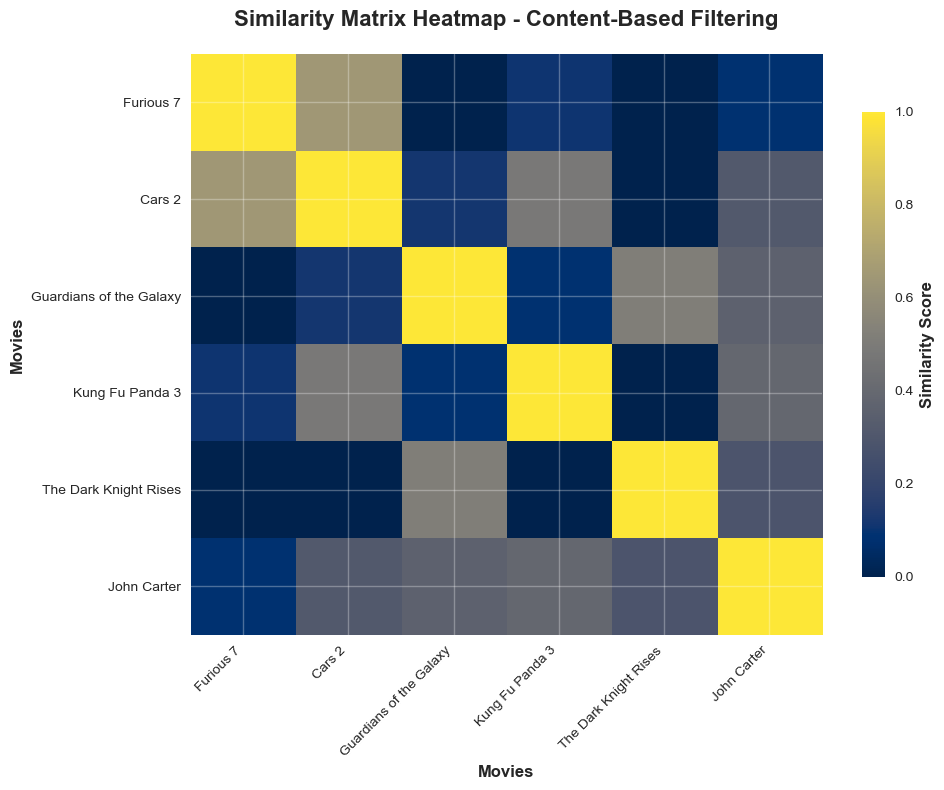

In [11]:
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='cividis', aspect='auto')

cbar = plt.colorbar(im, label='Similarity Score', shrink=0.8)
cbar.set_label('Similarity Score', size=12, weight='bold')

num_items = similarity_matrix.shape[0]
movie_titles = movies['title'].values if 'title' in movies.columns else [f'Movie {i}' for i in range(num_items)]

plt.xticks(range(num_items), movie_titles, rotation=45, ha='right', fontsize=10)
plt.yticks(range(num_items), movie_titles, fontsize=10)

plt.title("Similarity Matrix Heatmap - Content-Based Filtering", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Movies", fontsize=12, fontweight='bold')
plt.ylabel("Movies", fontsize=12, fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

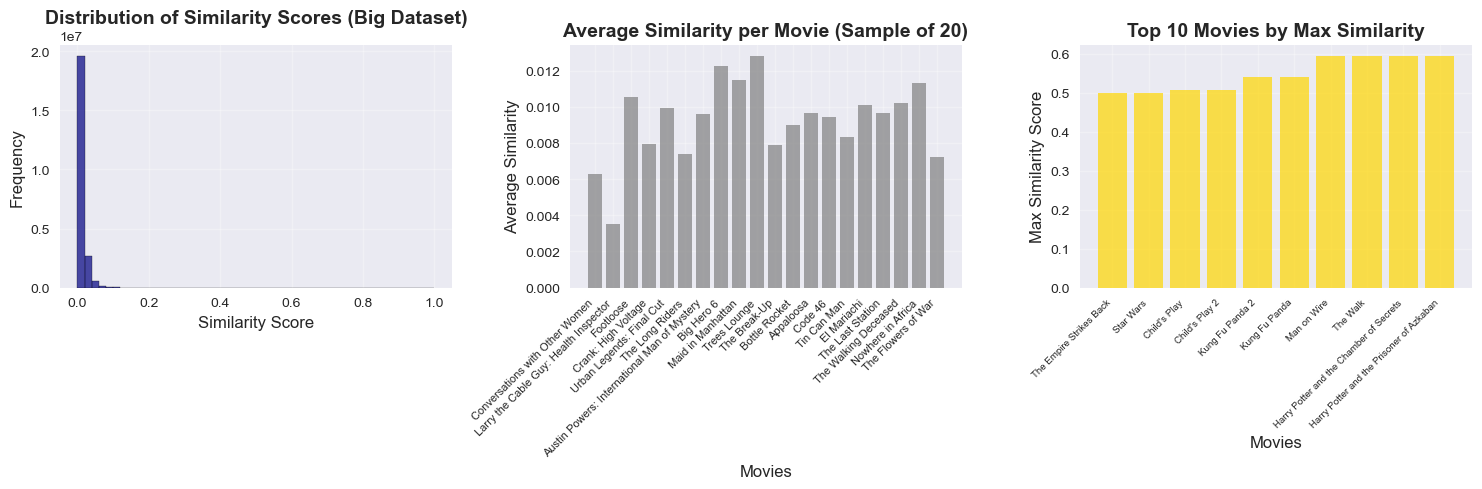

Dataset Size: 4803 movies
Total Similarity Comparisons: 23068809
Average Similarity Score: 0.0095
Standard Deviation: 0.0176


In [12]:
plt.figure(figsize=(15, 5))

np.random.seed(2)

plt.subplot(1, 3, 1)
similarity_values = similarity_matrix_big[similarity_matrix_big != 1.0].flatten()
plt.hist(similarity_values, bins=50, color='navy', edgecolor='black', alpha=0.7)
plt.title('Distribution of Similarity Scores (Big Dataset)', fontweight='bold')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
mean_similarity = np.mean(similarity_matrix_big, axis=1)
sample_size = min(20, len(mean_similarity))
sample_indices = np.random.choice(len(mean_similarity), sample_size, replace=False)
sample_mean_similarity = mean_similarity[sample_indices]

movie_titles_big = movies_big['title'].values if 'title' in movies_big.columns else [f'Movie {i}' for i in range(len(similarity_matrix_big))]
sample_titles = [movie_titles_big[i] for i in sample_indices]

bars = plt.bar(range(sample_size), sample_mean_similarity, color='grey', alpha=0.7)
plt.title(f'Average Similarity per Movie (Sample of {sample_size})', fontweight='bold')
plt.xlabel('Movies')
plt.ylabel('Average Similarity')
plt.xticks(range(sample_size), sample_titles, rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
similarity_without_diag = similarity_matrix_big.copy()
np.fill_diagonal(similarity_without_diag, 0)
max_similarities = np.max(similarity_without_diag, axis=1)
top_indices = np.argsort(max_similarities)[-10:]

plt.bar(range(10), max_similarities[top_indices], color='gold', alpha=0.7)
plt.title('Top 10 Movies by Max Similarity', fontweight='bold')
plt.xlabel('Movies')
plt.ylabel('Max Similarity Score')
plt.xticks(range(10), [movie_titles_big[i] for i in top_indices], rotation=45, ha='right', fontsize=7)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Dataset Size: {similarity_matrix_big.shape[0]} movies")
print(f"Total Similarity Comparisons: {similarity_matrix_big.shape[0] * similarity_matrix_big.shape[1]}")
print(f"Average Similarity Score: {np.mean(similarity_values):.4f}")
print(f"Standard Deviation: {np.std(similarity_values):.4f}")

In [13]:
def get_recommendations_by_index_big(idx, top_n=10):
    sims = similarity_matrix_big[idx].copy()
    sims[idx] = -1
    k = min(top_n, sims.shape[0]-1)
    top_idx = np.argpartition(sims, -k)[-k:]
    top_idx = top_idx[np.argsort(sims[top_idx])[::-1]]
    titles = movies_big['title'].values if 'title' in movies_big.columns else [f"Movie {i}" for i in range(sims.shape[0])]
    return [(int(i), titles[int(i)], float(sims[int(i)])) for i in top_idx]


def get_recommendations_by_title_big(title, top_n=10):
    if 'title' not in movies_big.columns:
        raise ValueError("Column 'title' not found in movies_big")
    match = movies_big[movies_big['title'].str.lower() == title.lower()]
    if match.empty:
        raise ValueError(f"Title '{title}' not found.")
    idx = int(match.index[0])
    return get_recommendations_by_index_big(idx, top_n=top_n)


def recommend_for_free_text(query_text, top_n=10, min_score=1e-9):
    qt = lemmatize_text(normalize_text(query_text))
    qv = tf_big.transform([qt])

    sims = linear_kernel(qv, tfidf_matrix_big).ravel()
    
    valid_mask = sims > min_score
    if not np.any(valid_mask):
        return []

    valid_idxs = np.where(valid_mask)[0]
    valid_scores = sims[valid_mask]

    k = min(top_n, valid_scores.shape[0])
    top_local = np.argpartition(valid_scores, -k)[-k:]
    top_local = top_local[np.argsort(valid_scores[top_local])[::-1]]

    top_idxs = valid_idxs[top_local]
    titles = movies_big['title'].values if 'title' in movies_big.columns else [f"Movie {i}" for i in range(sims.shape[0])]

    return [(int(i), titles[int(i)], float(sims[int(i)])) for i in top_idxs]


def plot_top_similar_for_title(title, color, top_n=10):
    recs = get_recommendations_by_title_big(title, top_n=top_n)
    labels = [r[1] for r in recs]
    scores = [r[2] for r in recs]
    plt.figure(figsize=(8,4))
    plt.barh(range(len(labels))[::-1], scores[::-1], color=color, alpha=0.85)
    plt.yticks(range(len(labels))[::-1], labels[::-1], fontsize=9)
    plt.xlabel('Similarity'); plt.title(f'Top-{top_n} similar to: {title}')
    plt.tight_layout(); plt.show()

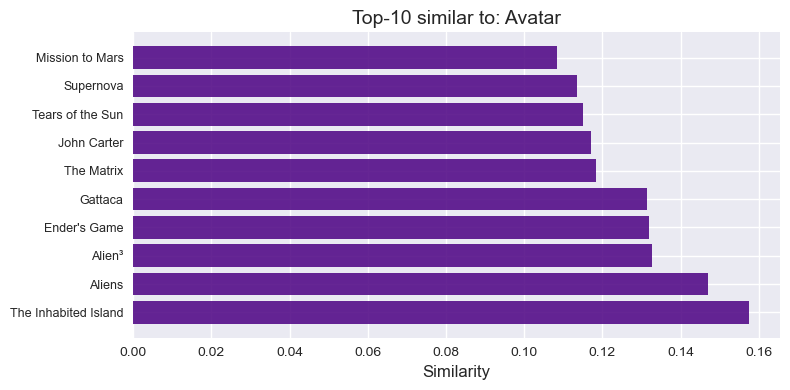

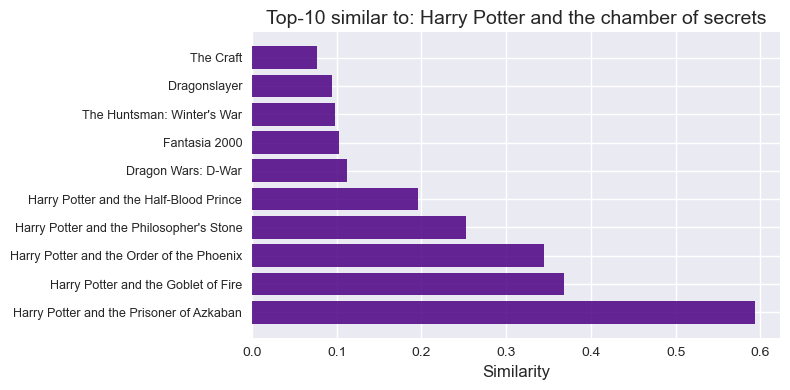

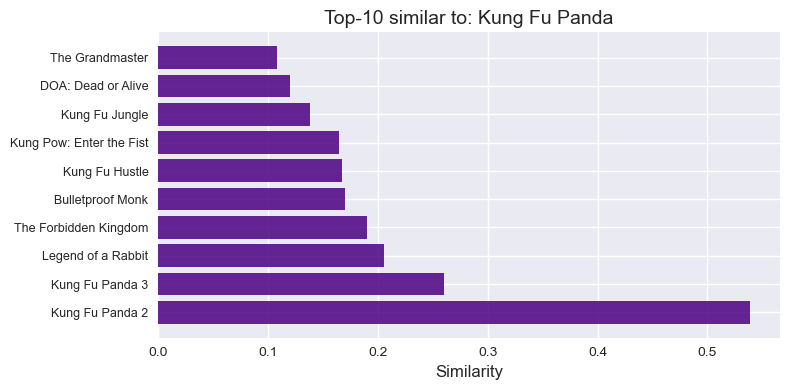

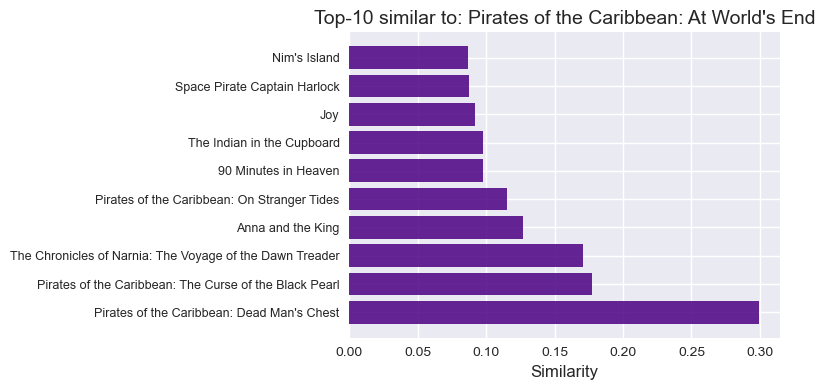

In [14]:
plot_top_similar_for_title('Avatar', 'indigo', 10)

plot_top_similar_for_title('Harry Potter and the chamber of secrets', 'indigo', 10)

plot_top_similar_for_title('Kung Fu Panda', 'indigo', 10)

plot_top_similar_for_title("Pirates of the Caribbean: At World's End", 'indigo', 10)

plt.show()

In [15]:
# recommend_for_free_text("a space marine on a distant moon fights aliens", 10)
# recommend_for_free_text("حبيبي", 10)
recommend_for_free_text("an alien", 10)

[(1482, 'The Darkest Hour', 0.22041046619415283),
 (1318, 'The Thing', 0.20862512290477753),
 (1198, 'Escape from Planet Earth', 0.20437714457511902),
 (141, 'Mars Needs Moms', 0.2030257135629654),
 (778, 'Meet Dave', 0.2023162990808487),
 (1163, 'Scary Movie 4', 0.1992926299571991),
 (2509, 'Slither', 0.1982501894235611),
 (564, 'Signs', 0.197653129696846),
 (972, 'The Host', 0.19636110961437225),
 (1068, "The Hitchhiker's Guide to the Galaxy", 0.1957041323184967)]

In [16]:
# get_recommendations_by_title_big('Avatar', top_n=10)
# get_recommendations_by_title_big('Harry Potter and the chamber of secrets', top_n=10)
# get_recommendations_by_title_big('Kung Fu Panda', top_n=10)
get_recommendations_by_title_big("Pirates of the Caribbean: At World's End", top_n=10)


[(12, "Pirates of the Caribbean: Dead Man's Chest", 0.2996988892555237),
 (199,
  'Pirates of the Caribbean: The Curse of the Black Pearl',
  0.17721439898014069),
 (109,
  'The Chronicles of Narnia: The Voyage of the Dawn Treader',
  0.1706555187702179),
 (536, 'Anna and the King', 0.12664443254470825),
 (17, 'Pirates of the Caribbean: On Stranger Tides', 0.11508265137672424),
 (3632, '90 Minutes in Heaven', 0.09789350628852844),
 (1074, 'The Indian in the Cupboard', 0.09768737852573395),
 (738, 'Joy', 0.09185468405485153),
 (1709, 'Space Pirate Captain Harlock', 0.08772668987512589),
 (1331, "Nim's Island", 0.08670828491449356)]